%%latem
\tableofcontents

# Preparations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

C:\ProgramData\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# ENV_NAME = 'colab'
ENV_NAME = 'local'
path_prefix = {'colab': '/content/drive/MyDrive/ComputerVision/CV-Phase1/', 
                'local': './Images/'}

Open image using pyplot:

In [3]:
def loadImage(name, path_prefix=path_prefix[ENV_NAME]):
  image = plt.imread(path_prefix + name)
  print(image.shape)
  print(type(image))
  return image

In [4]:
plt.gray()

<Figure size 432x288 with 0 Axes>

In [5]:
child = loadImage('im183.BMP')
vbar = loadImage('im184.bmp')

(1020, 987, 3)
<class 'numpy.ndarray'>
(1020, 987, 3)
<class 'numpy.ndarray'>


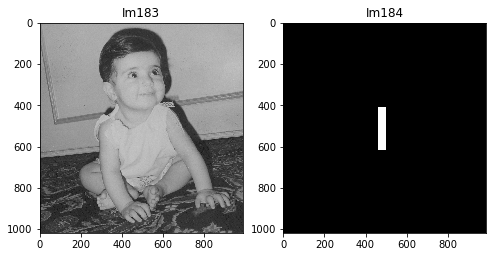

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(child)
axs[0].set_title('Im183')
axs[1].imshow(vbar)
axs[1].set_title('Im184')
plt.show()

In [59]:
einpotter = loadImage('im421.jpg')
einmonroe = loadImage('im423.jpg')

(367, 299, 3)
<class 'numpy.ndarray'>
(500, 600, 3)
<class 'numpy.ndarray'>


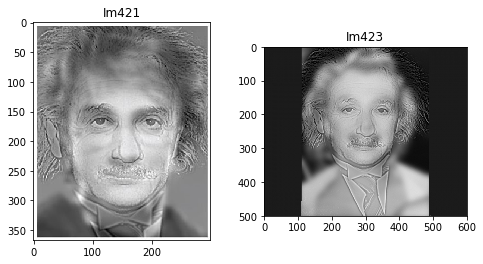

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(einpotter)
axs[0].set_title('Im421')
axs[1].imshow(einmonroe)
axs[1].set_title('Im423')
plt.show()

A function to convert 3-band rgb to greyscale is defined in the following cell:

In [61]:
def rgb2grey(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [62]:
child = rgb2grey(child)
vbar = rgb2grey(vbar)
einpotter = rgb2grey(einpotter)
einmonroe = rgb2grey(einmonroe)

# Fourier Transform

## Swapping Spectrums

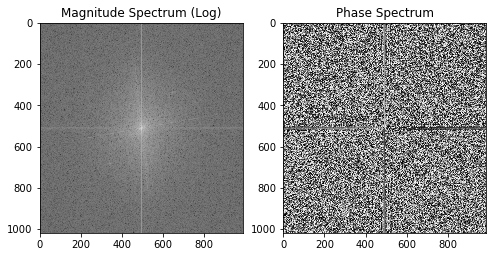

In [105]:
fchild = np.fft.fftshift(np.fft.fft2(child))
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.log(np.abs(fchild)))
axs[0].set_title('Magnitude Spectrum (Log)')
axs[1].imshow(np.angle(fchild))
axs[1].set_title('Phase Spectrum')
plt.show()

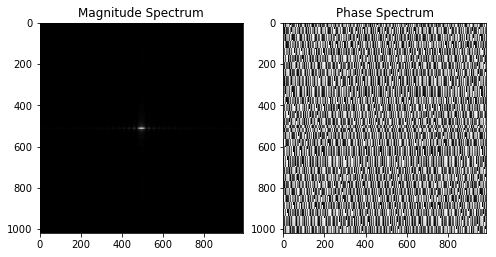

In [100]:
fvbar = np.fft.fftshift(np.fft.fft2(vbar))
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.abs(fvbar))
axs[0].set_title('Magnitude Spectrum')
axs[1].imshow(np.angle(fvbar))
axs[1].set_title('Phase Spectrum')
plt.show()

In [110]:
# inverse fourier transform from two separate images
def inverse_fourier(f1, f2):
    combined = np.abs(f1) * np.exp(1j * np.angle(f2))
    return np.fft.ifft2(combined)

Before mixing the spectrums, we do a test to see whether the inverse transform works correctly.

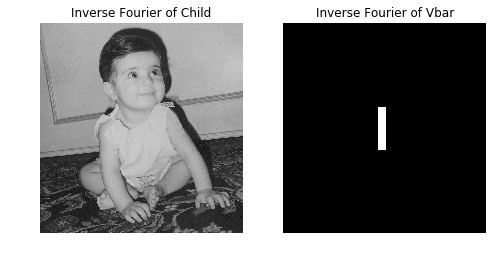

In [109]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ichild = inverse_fourier(fchild, fchild)
ivbar = inverse_fourier(fvbar, fvbar)
axs[0].imshow(abs(ichild))
axs[0].set_title('Inverse Fourier of Child')
axs[0].axis('off')
axs[1].imshow(abs(ivbar))
axs[1].set_title('Inverse Fourier of Vbar')
axs[1].axis('off')
plt.show()

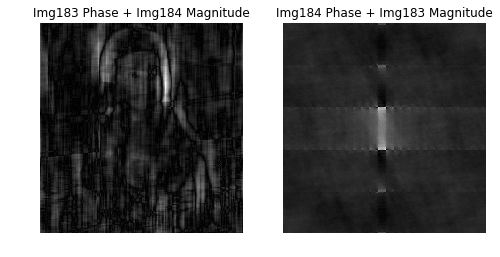

In [113]:
fused_child = inverse_fourier(fvbar, fchild)
fused_vbar = inverse_fourier(fchild, fvbar)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.abs(fused_child))
axs[0].set_title('Img183 Phase + Img184 Magnitude')
axs[0].axis('off')
axs[1].imshow(np.abs(fused_vbar))
axs[1].set_title('Img184 Phase + Img183 Magnitude')
axs[1].axis('off')
plt.show()

## Lowpass Filtering

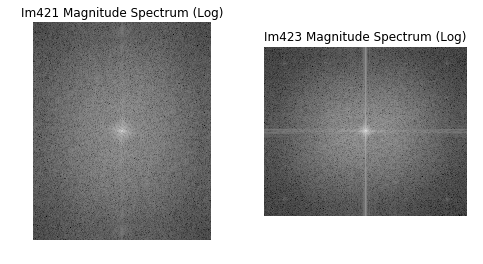

In [14]:
feinpotter = np.fft.fftshift(np.fft.fft2(einpotter))
feinmonroe = np.fft.fftshift(np.fft.fft2(einmonroe))
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.log(abs(feinpotter)))
axs[0].set_title('Im421 Magnitude Spectrum (Log)')
axs[1].imshow(np.log(abs(feinmonroe)))
axs[1].set_title('Im423 Magnitude Spectrum (Log)')
for i in range(2):
    axs[i].axis('off')
plt.show()

In [17]:
def gaussian_kernel(sigma, shape):
    x, y = np.mgrid[-shape[0]//2 + 1:shape[0]//2 + 1, -shape[1]//2 + 1:shape[1]//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    g = g / g.sum()    
    return g

Build a test Gaussian low pass kernel:

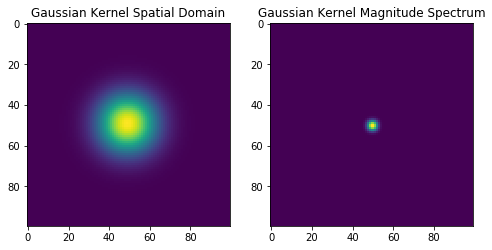

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
g = gaussian_kernel(10, (100, 100))
fg = np.fft.fftshift(np.fft.fft2(g))
axs[0].imshow(g, cmap='viridis')
axs[0].set_title('Gaussian Kernel Spatial Domain')
axs[1].imshow(np.abs(fg), cmap='viridis')
axs[1].set_title('Gaussian Kernel Magnitude Spectrum')
plt.show()

In [72]:
def apply_filter(img, filter):
    P = 2 * img.shape[0]
    Q = 2 * img.shape[1]
    img_padded = np.pad(img, ((0, P//2), (0, Q//2)), 'constant')
    img_padded = np.fft.fftshift(np.fft.fft2(img_padded))
    img_filtered = img_padded * filter
    img_filtered = np.fft.ifft2(np.fft.ifftshift(img_filtered))
    return img_filtered[img.shape[0]:, img.shape[1]:]

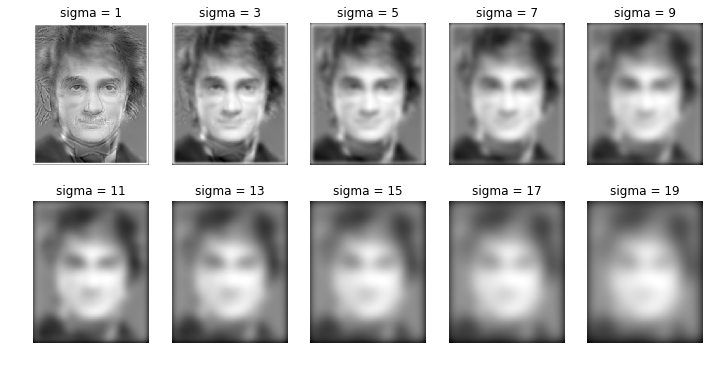

In [84]:
fig, axs  = plt.subplots(2, 5, figsize=(12, 6))
fep = []
ftfep = []
for s in range(10):
    g = gaussian_kernel(s*2 + 1, (einpotter.shape[0]*2, einpotter.shape[1]*2))
    fg = np.fft.fftshift(np.fft.fft2(g))
    ffep = apply_filter(einpotter, fg)
    fep.append(ffep)
    ftfep.append(np.fft.fftshift(np.fft.fft2(ffep)))
    axs[s//5, s%5].imshow(np.abs(ffep))
    axs[s//5, s%5].set_title('sigma = ' + str(s*2 + 1))
    axs[s//5, s%5].axis('off')
plt.show()

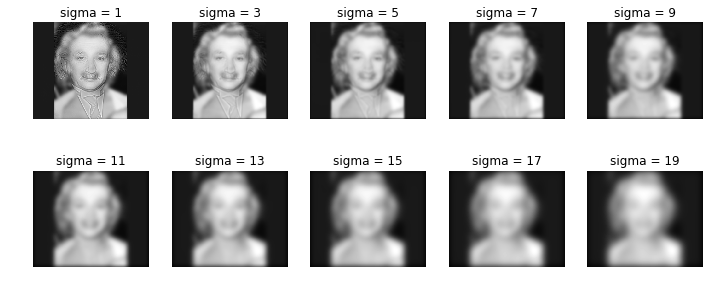

In [98]:
fig, axs  = plt.subplots(2, 5, figsize=(12, 5))
fem = []
ftfem = []
for s in range(10):
    g = gaussian_kernel(s*2 + 1, (einmonroe.shape[0]*2, einmonroe.shape[1]*2))
    fg = np.fft.fftshift(np.fft.fft2(g))
    ffem = apply_filter(einmonroe, fg)
    fem.append(ffem)
    ftfem.append(np.fft.fftshift(np.fft.fft2(ffem)))
    axs[s//5, s%5].imshow(np.abs(ffem))
    axs[s//5, s%5].set_title('sigma = ' + str(s*2 + 1))
    axs[s//5, s%5].axis('off')
plt.show()

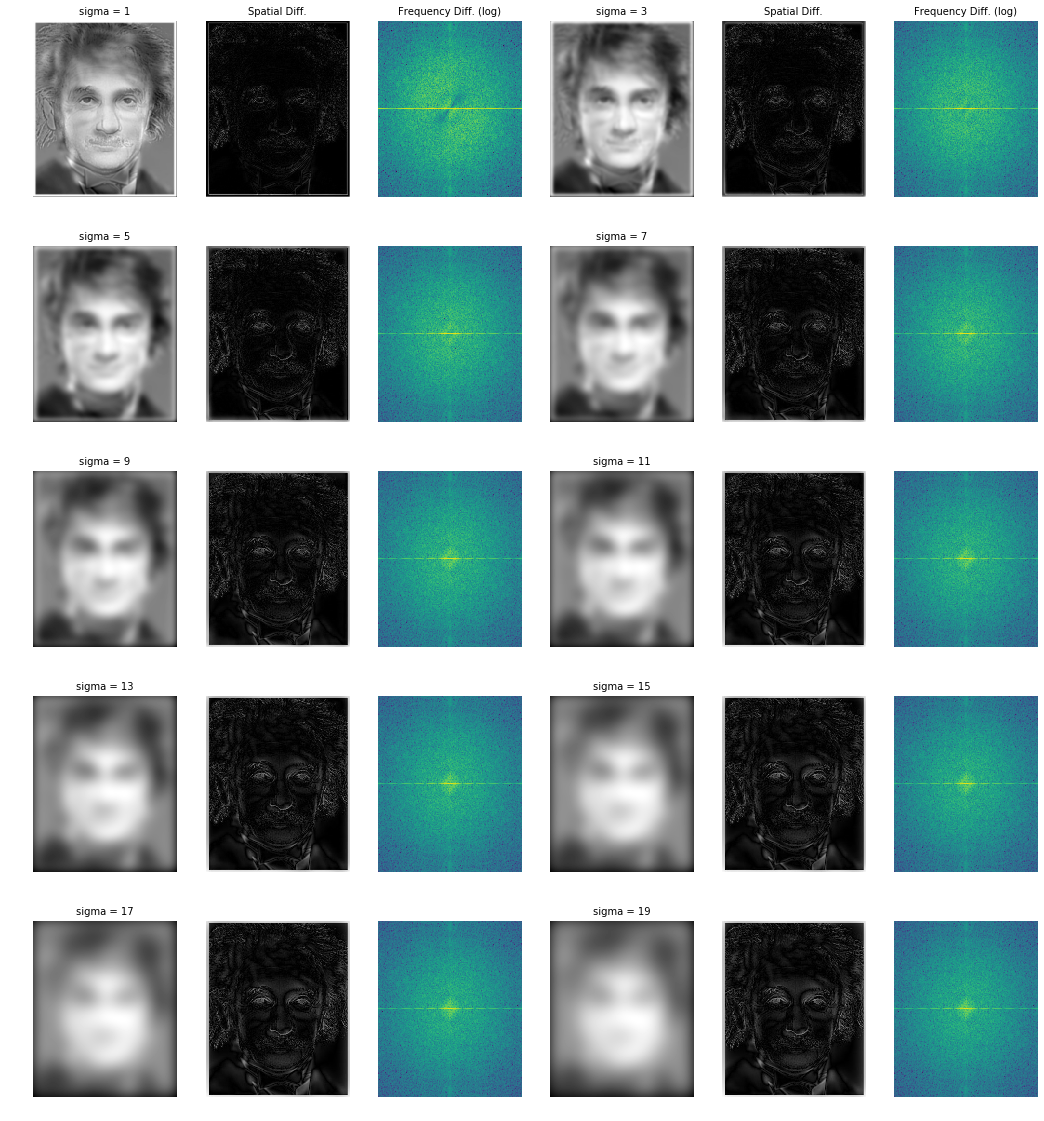

In [96]:
fig, axs = plt.subplots(5, 6, figsize=(18, 20))
axs[0,1].set_title('Spatial Diff.', fontsize=10)
axs[0,4].set_title('Spatial Diff.', fontsize=10)
axs[0,2].set_title('Frequency Diff. (log)', fontsize=10)
axs[0,5].set_title('Frequency Diff. (log)', fontsize=10)
for i in range(10):
    axs[i * 3//6, (i * 3 %6)].imshow(abs(fep[i]))
    axs[i * 3//6, (i * 3 %6)].set_title('sigma = ' + str(i*2 + 1), fontsize=10)
    axs[i * 3//6, (i * 3 %6)].axis('off')
    axs[i * 3//6, (i * 3 %6) + 1].imshow(abs(einpotter - abs(fep[i])))
    axs[i * 3//6, (i * 3 %6) + 1].axis('off')
    axs[i * 3//6, (i * 3 %6) + 2].imshow(np.log(abs(ftfep[i] - feinpotter)), cmap='viridis')
    axs[i * 3//6, (i * 3 %6) + 2].axis('off')
plt.show()

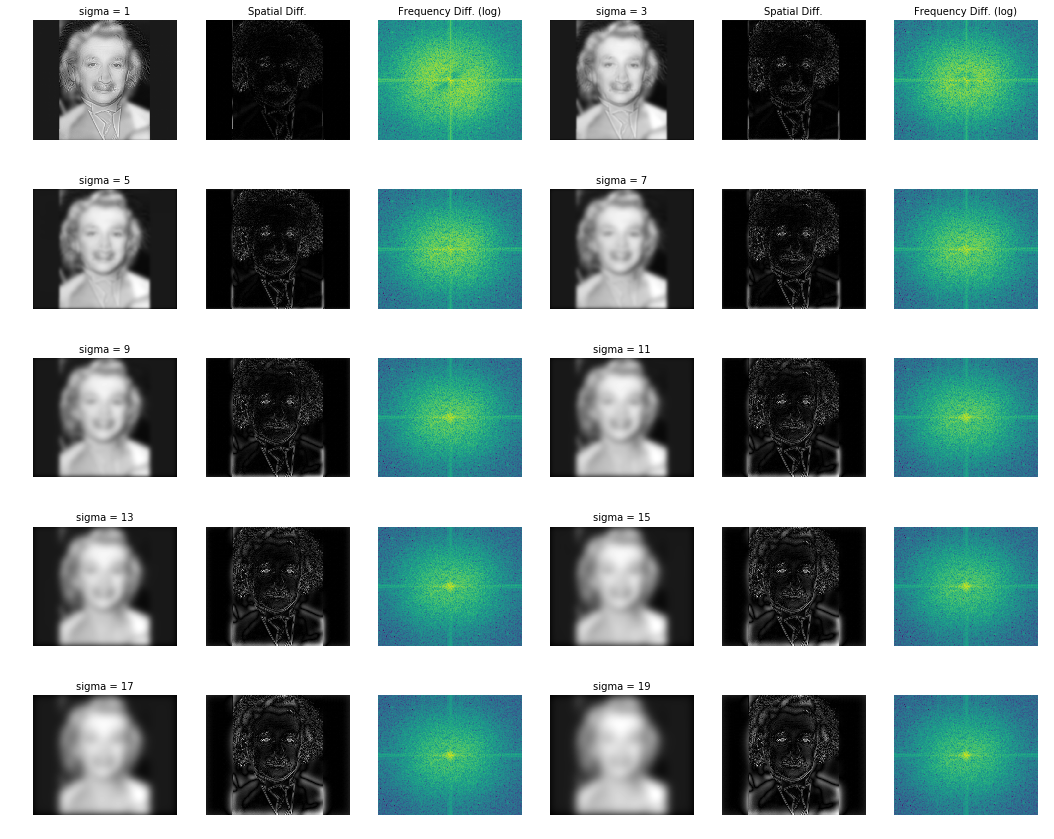

In [100]:
fig, axs = plt.subplots(5, 6, figsize=(18, 15))
axs[0,1].set_title('Spatial Diff.', fontsize=10)
axs[0,4].set_title('Spatial Diff.', fontsize=10)
axs[0,2].set_title('Frequency Diff. (log)', fontsize=10)
axs[0,5].set_title('Frequency Diff. (log)', fontsize=10)
for i in range(10):
    axs[i * 3//6, (i * 3 %6)].imshow(abs(fem[i]))
    axs[i * 3//6, (i * 3 %6)].set_title('sigma = ' + str(i*2 + 1), fontsize=10)
    axs[i * 3//6, (i * 3 %6)].axis('off')
    axs[i * 3//6, (i * 3 %6) + 1].imshow(abs(einmonroe - abs(fem[i])))
    axs[i * 3//6, (i * 3 %6) + 1].axis('off')
    axs[i * 3//6, (i * 3 %6) + 2].imshow(np.log(abs(ftfem[i] - feinmonroe)), cmap='viridis')
    axs[i * 3//6, (i * 3 %6) + 2].axis('off')
plt.show()

## Superimposing Images

For this purpose, two images from the book are used: `bio.tif` and `typeset.tif`.

In [105]:
bio = loadImage('bio.tif')
tset = loadImage('typeset.tif')

(500, 500)
<class 'numpy.ndarray'>
(500, 500)
<class 'numpy.ndarray'>


In [106]:
fbio = np.fft.fftshift(np.fft.fft2(bio))
ftset = np.fft.fftshift(np.fft.fft2(tset))

In [103]:
def ideal_kernel(shape, r):
    kernel = np.zeros(shape, dtype=np.bool)
    center = np.array(kernel.shape)/2.0
    for y in range(shape[0]):
        for x in range(shape[1]):
            kernel[y, x] = (y - center[0])**2 + (x - center[1])**2 < r**2
    return kernel

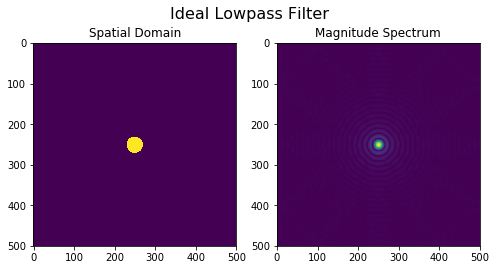

In [107]:
lopass = ideal_kernel(bio.shape, 20)
flopass = np.fft.fftshift(np.fft.fft2(lopass))
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(lopass, cmap='viridis')
axs[0].set_title('Spatial Domain')
axs[1].imshow(np.abs(flopass), cmap='viridis')
axs[1].set_title('Magnitude Spectrum')
fig.suptitle('Ideal Lowpass Filter', fontsize=16)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


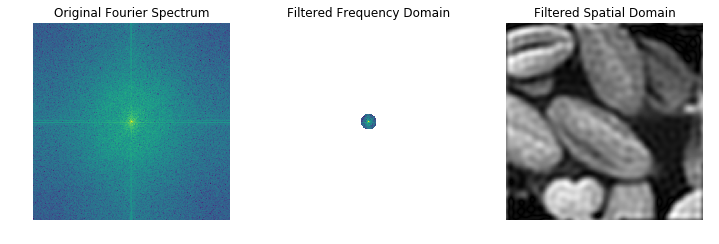

In [108]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
ffbio = np.zeros(fbio.shape, dtype=np.complex)
ffbio[lopass] = fbio[lopass]
ifbio = np.fft.ifft2(ffbio)
axs[0].imshow(np.log(np.abs(fbio)), cmap='viridis')
axs[0].set_title('Original Fourier Spectrum')
axs[1].imshow(np.log(np.abs(ffbio)), cmap='viridis')
axs[1].set_title('Filtered Frequency Domain')
axs[2].imshow(np.abs(ifbio))
axs[2].set_title('Filtered Spatial Domain')
for i in range(3):
    axs[i].axis('off')
plt.show()


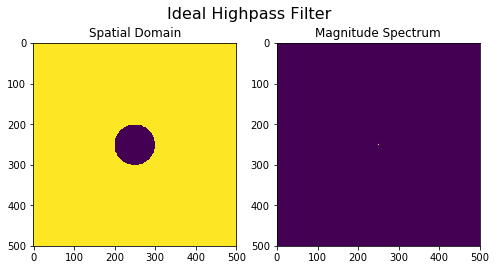

In [114]:
hipass = ~ideal_kernel(bio.shape, 50)
fhipass = np.fft.fftshift(np.fft.fft2(hipass))
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(hipass, cmap='viridis')
axs[0].set_title('Spatial Domain')
axs[1].imshow(np.abs(fhipass), cmap='viridis')
axs[1].set_title('Magnitude Spectrum')
fig.suptitle('Ideal Highpass Filter', fontsize=16)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


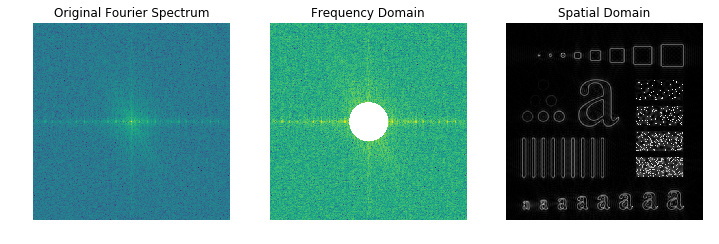

In [113]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fftset = np.zeros(ftset.shape, dtype=np.complex)
fftset[hipass] = ftset[hipass]
iftset = np.fft.ifft2(fftset)
axs[0].imshow(np.log(np.abs(ftset)), cmap='viridis')
axs[0].set_title('Original Fourier Spectrum')
axs[1].imshow(np.log(np.abs(fftset)), cmap='viridis')
axs[1].set_title('Frequency Domain')
axs[2].imshow(np.abs(iftset))
axs[2].set_title('Spatial Domain')
for i in range(3):
    axs[i].axis('off')
plt.show()

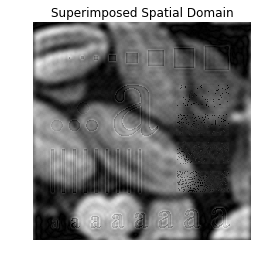

In [130]:
superimposed = ifbio//2 + iftset//6
plt.imshow(np.abs(superimposed), cmap='gray')
plt.axis('off')
plt.title('Superimposed Spatial Domain')
plt.show()

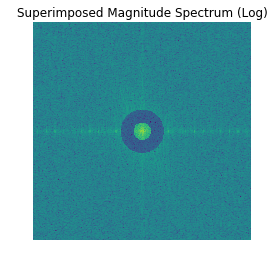

In [131]:
fsuperimposed = np.fft.fft2(superimposed)
plt.imshow(np.log(abs(fsuperimposed)), cmap='viridis')
plt.axis('off')
plt.title('Superimposed Magnitude Spectrum (Log)')
plt.show()